In [18]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [34]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [77]:
batch_size = 10
num_epochs = 3
learning_rate = 0.001

In [78]:
dataset=datasets.ImageFolder(root=("./shapes"),transform=train_transform)
dataset

Dataset ImageFolder
    Number of datapoints: 14970
    Root location: ./shapes
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [79]:
class_names=dataset.classes
print(class_names)
print(len(class_names))

['circle', 'square', 'star', 'triangle']
4


In [80]:
from sklearn.model_selection import train_test_split
train_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets)
train_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)

In [81]:
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size)

In [82]:
len(train_data)
len(test_data)

2994

In [83]:
for images, labels in train_loader:
    break
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=5)

Label: [0 0 3 3 1 3 2 1 0 1]
Class: circle circle triangle triangle square triangle star square circle square


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


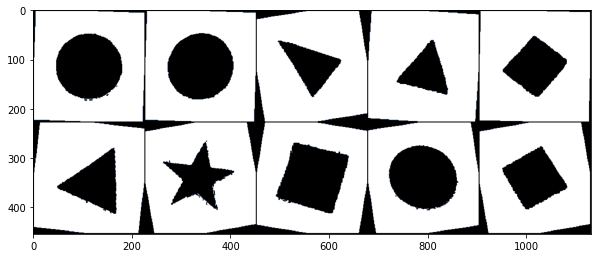

In [84]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

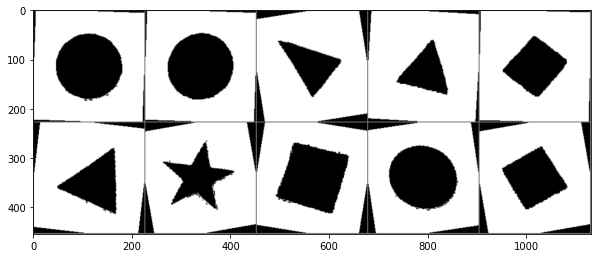

In [85]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                     std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [86]:
class DNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(150528,120),  
            nn.BatchNorm1d(120),    
            nn.ReLU()    
        )
        self.layer2 = nn.Sequential(
            nn.Linear(120,4)    
            
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        return x_out

In [87]:
def weights_init(m):
    if isinstance(m, nn.Linear): 
        nn.init.xavier_normal_(m.weight) # Weight를 xavier_normal로 초기화
        print(m.weight)

In [88]:
torch.manual_seed(7777)
model = DNN()
model.apply(weights_init)

Parameter containing:
tensor([[-0.0044, -0.0015, -0.0033,  ..., -0.0035,  0.0015, -0.0013],
        [-0.0004, -0.0060, -0.0019,  ...,  0.0009, -0.0054, -0.0089],
        [-0.0018, -0.0040, -0.0093,  ...,  0.0023, -0.0005,  0.0022],
        ...,
        [ 0.0045, -0.0029,  0.0030,  ...,  0.0028,  0.0039, -0.0040],
        [-0.0006, -0.0009, -0.0036,  ...,  0.0002,  0.0004, -0.0034],
        [ 0.0027, -0.0021, -0.0033,  ...,  0.0001,  0.0022, -0.0002]],
       requires_grad=True)
Parameter containing:
tensor([[ 1.7936e-01, -8.6747e-03, -7.0655e-02,  2.1355e-01,  2.4844e-01,
         -5.1907e-03, -2.0638e-01, -5.9076e-02,  1.7127e-02, -6.3150e-02,
         -1.1536e-01, -6.1598e-02, -1.1225e-01, -1.2599e-01, -1.1553e-02,
         -1.3719e-01, -5.0001e-02, -4.3275e-02, -8.1746e-02,  3.4173e-02,
         -1.1853e-01,  5.3149e-03, -1.3357e-01, -1.0338e-01,  3.1764e-02,
         -4.8573e-02, -5.1329e-02,  1.2978e-01,  2.6717e-01, -1.0925e-02,
          2.6518e-02,  1.9203e-02, -2.1942e-01,  1.

DNN(
  (layer1): Sequential(
    (0): Linear(in_features=150528, out_features=120, bias=True)
    (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=120, out_features=4, bias=True)
  )
)

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [90]:
for epoch in range(num_epochs):
    for i, (X_train, y_train) in enumerate(train_loader):
        y_pred = model(X_train)  
        loss = criterion(y_pred, y_train)    
        
        optimizer.zero_grad()           
        loss.backward()          
        optimizer.step()            
        
        _, argmax = torch.max(y_pred, 1)
        accuracy = (y_train == argmax).float().mean()
        
        if (i+1) % 50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                epoch+1, num_epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))

Epoch [1/3], Step [50/1198], Loss: 0.4588, Accuracy: 100.00%
Epoch [1/3], Step [100/1198], Loss: 0.1805, Accuracy: 100.00%
Epoch [1/3], Step [150/1198], Loss: 0.1699, Accuracy: 100.00%
Epoch [1/3], Step [200/1198], Loss: 0.1717, Accuracy: 90.00%
Epoch [1/3], Step [250/1198], Loss: 0.0405, Accuracy: 100.00%
Epoch [1/3], Step [300/1198], Loss: 0.0259, Accuracy: 100.00%
Epoch [1/3], Step [350/1198], Loss: 0.0585, Accuracy: 100.00%
Epoch [1/3], Step [400/1198], Loss: 0.0404, Accuracy: 100.00%
Epoch [1/3], Step [450/1198], Loss: 0.2332, Accuracy: 90.00%
Epoch [1/3], Step [500/1198], Loss: 0.0743, Accuracy: 100.00%
Epoch [1/3], Step [550/1198], Loss: 0.0198, Accuracy: 100.00%
Epoch [1/3], Step [600/1198], Loss: 0.0428, Accuracy: 100.00%
Epoch [1/3], Step [650/1198], Loss: 0.0605, Accuracy: 100.00%
Epoch [1/3], Step [700/1198], Loss: 0.0137, Accuracy: 100.00%
Epoch [1/3], Step [750/1198], Loss: 0.0281, Accuracy: 100.00%
Epoch [1/3], Step [800/1198], Loss: 0.0246, Accuracy: 100.00%
Epoch [1/3]

In [92]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs, labels
        outputs = model(imgs)
        _, argmax = torch.max(outputs, 1) 
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()
    
    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))

Test accuracy for 2994 images: 99.93%
